# 量的データ用（For quantitaive data）
[Methods]  
- Clustering methods : Kmeans, GMM, FSSEM, FSS-Kmeans    
- Allocation methods : random, proportional allocation, post stratification, optimal allocation

-------------
### ライブラリのインポート＆その他の設定（Importing Libraries & Other Settings）

In [1]:
# 基本的なライブラリ
import numpy as np
import pandas as pd
from numpy.typing import NDArray
from scipy import stats

# Scikit-learn関連
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.utils.validation import check_X_y
from sklearn.metrics import silhouette_score

# 抽象基底クラス (ABC)
from abc import ABCMeta, abstractmethod

# タイピングのサポート
from typing import Optional

# シード設定
from lightning.pytorch import seed_everything

seed_everything(8)

# 可視化の設定
import matplotlib.pyplot as plt
import japanize_matplotlib
import itertools

plt.style.use("ggplot")

Seed set to 8


--------
### 実験設定

In [2]:
THRESHOLD = 2  # 外れ値除外のための閾値

SAMPLE_SIZE = 100  # 標本サイズ
DATA_SIZE = 100000  # データサイズ(df2)
N_TRIALS = 100  # 試行回数（標本平均を求める回数）
N_EXPERIMENT = 10  # 誤差分散を求める回数
m_VALUE = 2  # 各クラスタの最小標本数(最適標本配分)
RANDOM_STATE = 0  # 乱数シード
ALLOCATION_LIST = ["Proportional", "Post", "Optimal"]
ALLOCATION_LIST_AND_RANDOM = [
    "Random",
    "Proportional",
    "Post",
    "Optimal",
]
CRITERION_LIST = ["checking"]  # [ "checking"]
CLUSTERING_METHOD_LIST = ["gmm", "kmeans", "xmeans"]  # ["gmm", "kmeans", "xmeans"]


# クラスタ数を固定する場合（Kmeans, GMM)
N_CLUSTERS = 2  # クラスタ数(固定の場合)

# クラスタ数を固定しない場合(xmeans)
K_MIN = 2  # 最小クラスタ数
K_MAX = 8  # 最大クラスタ数


FEATURES_LIST_CHECKING = [5]
RANDOM_STD_FIXED = "no"  # "no", int

stratification_methods = list(itertools.product(CRITERION_LIST, CLUSTERING_METHOD_LIST))

METHODS_NAME_DICT = {}
for method in stratification_methods:
    if method == ("checking", "kmeans"):
        METHODS_NAME_DICT[method] = "Kmeans-checking"
    if method == ("checking", "xmeans"):
        METHODS_NAME_DICT[method] = "Xmeans-checking"
    if method == ("checking", "gmm"):
        METHODS_NAME_DICT[method] = "GMM-checking"
print("METHODS_NAME_DICT", METHODS_NAME_DICT)

METHODS_NAME_DICT {('checking', 'gmm'): 'GMM-checking', ('checking', 'kmeans'): 'Kmeans-checking', ('checking', 'xmeans'): 'Xmeans-checking'}


-----------
### データの前処理（Data Preprocessing）

##### 外れ値を除去する関数

In [3]:
# 外れ値の除去
def remove_outliers_zscore(
    data: pd.DataFrame, metric: str, threshold: float = 2
) -> pd.DataFrame:
    z_scores = np.abs(stats.zscore(data[metric]))
    data = data[(z_scores < threshold)]
    return data

##### メルカリデータ（df1：全部, df2：一部）

In [4]:
# df1(all the data)
df1 = pd.read_csv(
    R"C:\Users\HaruMomozu\Documents\aug_first_cpn_data_for_ab_test_sensibility_tsukuba.csv"
)
obj1 = "GMV"
features_list1 = [
    "hist_4_day_buy_num",
    "hist_4_day_gmv",
    "his_4_day_is_buy",
    "hist_30_day_buy_days",
    "hist_30_day_buy_num",
    "hist_30_day_gmv",
    "hist_30_day_buy_recency",
    "hist_30_day_pay_days",
    "hist_30_day_atpu",
    "hist_30_day_gpv",
    "hist_30_day_pay_recency",
    "hist_30_day_list_days",
    "hist_30_day_list_num",
    "hist_30_day_list_recency",
    "hist_30_day_like_count",
    "hist_30_day_like_count_not_deleted",
    "hist_30_day_like_recency",
]

# df2(subset of the data)
df2 = df1.iloc[:DATA_SIZE]
obj2 = obj1
features_list2 = features_list1

##### 外れ値除去と標準化

In [5]:
df = df2  # choose from (df1, df2)
obj = obj2  # choose from (obj1, obj2)
features_list = features_list2  # choose from (features_list1, features_list2)

# 外れ値除去
df = remove_outliers_zscore(data=df, metric=obj, threshold=THRESHOLD)

# 標準化
X = df[features_list]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(X)
X_scaled = pd.DataFrame(scaled_features, columns=features_list)

# 目的変数
y = df[obj]

# 行を詰める
df = df.reset_index(drop=True)

print("外れ値除外前のデータ数:", DATA_SIZE)
print("外れ値除外後のデータ数:", len(df))

外れ値除外前のデータ数: 100000
外れ値除外後のデータ数: 99082


-------------
### 選ばれた特徴量でクラスタリング

In [6]:
def compute_bic(X, kmeans):
    labels = kmeans.labels_
    clusters = kmeans.cluster_centers_
    n_clusters = len(clusters)
    n = len(X)
    m = X.shape[1]
    variance = np.sum(
        [
            np.linalg.norm(X[labels == i] - clusters[i], axis=1).sum()
            for i in range(n_clusters)
        ]
    )
    bic = np.log(n) * n_clusters * m + n * np.log(variance / n)
    return bic


def xmeans(X, k_min=2, k_max=10):
    kmeans = KMeans(n_clusters=k_min, random_state=RANDOM_STATE)
    kmeans.fit(X)
    best_bic = compute_bic(X, kmeans)
    best_kmeans = kmeans
    for k in range(k_min + 1, k_max + 1):
        kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE)
        kmeans.fit(X)
        current_bic = compute_bic(X, kmeans)
        if current_bic < best_bic:
            best_bic = current_bic
            best_kmeans = kmeans
    return best_kmeans

In [7]:
cluster_label_dict = {}
cluster_size_dict = {}
N_CLUSTER_DICT = {}

clustering_methods = []
for method, name in METHODS_NAME_DICT.items():
    if method[0] == "checking":
        clustering_methods.append(name)
        if method[1] == "kmeans":
            model = KMeans(n_clusters=N_CLUSTERS, random_state=RANDOM_STATE)
        if method[1] == "gmm":
            model = GaussianMixture(
                n_components=N_CLUSTERS, random_state=RANDOM_STATE, init_params="kmeans"
            )
        if method[1] == "xmeans":
            model = xmeans(
                X_scaled.iloc[:, FEATURES_LIST_CHECKING], k_min=K_MIN, k_max=K_MAX
            )

        labels = model.fit_predict(X_scaled.iloc[:, FEATURES_LIST_CHECKING])
        cluster_size = np.bincount(labels)
        n_clusters = len(np.unique(labels))

        cluster_label_dict[name] = labels
        cluster_size_dict[name] = cluster_size
        N_CLUSTER_DICT[name] = n_clusters

        print("[", name, "]")
        print("各層のクラスタサイズ : ", cluster_size_dict[name])
        print("クラスタラベル：", cluster_label_dict[name])
        print("クラスタ数：", N_CLUSTER_DICT[name])
        print()


c:\Users\HaruMomozu\Desktop\momozu\ABtesting\.venv\Lib\site-packages\threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[ GMM-checking ]
各層のクラスタサイズ :  [84818 14264]
クラスタラベル： [0 0 0 ... 0 0 0]
クラスタ数： 2

[ Kmeans-checking ]
各層のクラスタサイズ :  [97547  1535]
クラスタラベル： [0 0 0 ... 0 0 0]
クラスタ数： 2

[ Xmeans-checking ]
各層のクラスタサイズ :  [70834   428  5860     3    17   103 20228  1609]
クラスタラベル： [0 6 0 ... 0 0 0]
クラスタ数： 8



-----------------------------
### 標本配分（Allocation)

In [8]:
print("N_CLUSTER_DICT:", N_CLUSTER_DICT)
print("cluster_label_dict", cluster_label_dict)
print("cluster_size_dict", cluster_size_dict)

N_CLUSTER_DICT: {'GMM-checking': 2, 'Kmeans-checking': 2, 'Xmeans-checking': 8}
cluster_label_dict {'GMM-checking': array([0, 0, 0, ..., 0, 0, 0], dtype=int64), 'Kmeans-checking': array([0, 0, 0, ..., 0, 0, 0]), 'Xmeans-checking': array([0, 6, 0, ..., 0, 0, 0])}
cluster_size_dict {'GMM-checking': array([84818, 14264], dtype=int64), 'Kmeans-checking': array([97547,  1535], dtype=int64), 'Xmeans-checking': array([70834,   428,  5860,     3,    17,   103, 20228,  1609],
      dtype=int64)}


##### 基底クラス

In [9]:
class BaseAllocation(metaclass=ABCMeta):  # 抽象基底クラス（ABC）
    # 初期化クラス（n_samples(標本サイズ), H(クラスタ数)）
    def __init__(
        self,
        sample_size: int,
        H: int,
        random_state: int,
        criterion: str,
        clustering_method: str,
        methods_name_dict: dict,
    ):
        self.sample_size = sample_size
        self.H = H
        self.random_state = random_state
        self.criterion = criterion
        self.clustering_method = clustering_method
        self.methods_name_dict = methods_name_dict

    @abstractmethod
    def solve(self, X: NDArray, y: NDArray) -> NDArray:
        """標本配分を解く

        Args:
            X (NDArray): データ (N x M)
            y (NDArray): 目的変数 (N)

        Raises:
            NotImplementedError: _description_

        Returns:
            NDArray: 各クラスタの標本数 (H, )

        Note:
            M: 特徴量数
            H: クラスタ数
        """
        # 具象クラスがsolveメゾッドを実装しない場合はNotImpleamentedErrorが発生
        raise NotImplementedError

    def clustering(self, X: NDArray) -> tuple[NDArray, NDArray]:
        for method, name in self.methods_name_dict.items():
            if method[0] == self.criterion and method[1] == self.clustering_method:
                cluster_label = cluster_label_dict[name]
                cluster_size = cluster_size_dict[name]

        # インスタンス変数として設定
        self.cluster_label = cluster_label
        self.N = cluster_size

        return cluster_label, cluster_size

##### 単純無作為抽出のクラス

In [10]:
class Random(BaseAllocation):
    # 抽象メゾッドを具象化
    def solve(self, X: NDArray, y: NDArray) -> NDArray:
        """ランダムにn_samplesの標本を選択する"""
        n = np.array([self.sample_size])
        return n

    def clustering(self, X: NDArray) -> tuple[NDArray, NDArray]:
        # cluster_labelのすべての要素は0（すべてのデータを同じクラスタに属させている）
        cluster_label = np.zeros(
            X.shape[0]
        )  # cluster_label = [0,0,0,,...(要素数：データ数）]
        # クラスタサイズ＝データ数
        cluster_size = np.array([len(cluster_label)])  # cluster_size=[データ数]
        return cluster_label, cluster_size

##### 比例配分のクラス

In [11]:
class Proportional(BaseAllocation):
    def solve(self, X: NDArray, y: NDArray) -> NDArray:
        """各クラスタ数に比例した標本数で分割する"""
        n: NDArray = np.round(self.N / self.N.sum() * self.sample_size).astype(int)

        if n.sum() > self.sample_size:
            # nの合計がn_samplesより大きい場合は一番標本数が多いクラスタから削る
            n[np.argmax(n)] -= n.sum() - self.sample_size

        if n.sum() < self.sample_size:
            # nの合計がn_samplesより小さい場合は一番標本数が多いクラスタにたす
            n[np.argmax(n)] += -n.sum() + self.sample_size

        return n

##### 事後層化のクラス

In [12]:
class Post(BaseAllocation):
    def solve(self, X: NDArray, y: NDArray) -> NDArray:
        """ランダムにn_samplesの標本を選択する"""
        n = np.array([self.sample_size])

        return n  # （例）n=[標本サイズ]

##### 最適標本配分のクラス

In [13]:
class Optimal(BaseAllocation):
    def __init__(
        self,
        sample_size: int,
        H: int,
        m: NDArray,  # 標本サイズ下限
        M: Optional[NDArray] = None,  # 標本サイズ上限 #Optional(Noneである可能性がある)
        random_state: int = 0,
        criterion: str = "tr",
        clustering_method: str = "kmeans",
        methods_name_dict: dict = {},
    ):
        super().__init__(
            sample_size,
            H,
            random_state,
            criterion,
            clustering_method,
            methods_name_dict,
        )  # 基底クラスBaseAllocation（スーパークラス）の初期化メゾッドを呼び出す
        self.m = m  # 各クラスタの最小標本サイズ (H, )
        self.M = M  # 各クラスタの最大標本サイズ (H, ), (指定しない場合はクラスタサイズ)

    def solve(self, X: NDArray, y: NDArray) -> NDArray:
        # S:クラスタ毎の目的変数のvarianceを要素とする配列 (H, )
        S = np.array([np.var(y[self.cluster_label == h]) for h in range(self.H)])
        d = (self.N**2) * S  # (H, )
        n = self._simple_greedy(n=self.m.copy(), d=d)

        # 制約チェック
        self._check_constraints(n)

        return n

    def _simple_greedy(self, n: NDArray, d: NDArray) -> NDArray:
        M = self.M.copy() if self.M is not None else self.N.copy()
        I = np.arange(self.H)  # noqa #クラスタのインデックス
        while (n.sum() != self.sample_size) and len(I) != 0:
            delta = np.zeros(self.H)
            delta[I] = (d / (n + 1) - d / n)[I]
            h_star = np.argmin(delta[I])
            h_star = I[h_star]

            if n[h_star] + 1 <= M[h_star]:
                n[h_star] = n[h_star] + 1
            else:
                # Iの要素h_starを削除
                I_ = I.tolist()
                I_ = [i for i in I_ if i != h_star]
                I = np.array(I_)  # noqa

        return n

    def _check_constraints(self, n: NDArray):
        assert (
            n.sum() <= self.sample_size
        ), f"Total sample size is over than {self.sample_size}"
        assert np.all(n >= self.m), "Minimum sample size constraint is not satisfied"
        if self.M is not None:
            assert np.all(
                n <= self.M
            ), "Maximum sample size constraint is not satisfied"

##### 母平均の推定値を計算する関数

In [14]:
def estimate_y_mean(n: NDArray, cluster_label: NDArray, y: NDArray) -> NDArray:
    """実際にサンプリングを行って目的変数の平均を推定

    Args:
        n (NDArray): 各クラスタの標本数 (H, )
        cluster_label (NDArray): クラスタラベル (N, )
        y (NDArray): 目的変数 (N, )

    Returns:
        NDArray: 推定された目的変数の平均

    Note:
        N: データ数
        H: クラスタ数
    """
    # cluster_labelからユニークなクラスタラベルを取得し、母集団の各クラスタのサイズNを取得
    N = np.unique(cluster_label, return_counts=True)[1]  # クラスタサイズ (H, )
    weights = N / N.sum()
    y_hat = 0
    for h in range(n.shape[0]):  # n.shape[0]:層の数
        if n[h] != 0:
            y_cluster = y[cluster_label == h]
            if n[h] <= len(y_cluster):
                sample: NDArray = np.random.choice(y_cluster, n[h], replace=False)
                y_sample_mean = sample.mean()  # サンプリングした標本の平均
                y_hat += y_sample_mean * weights[h]

    return y_hat


def estimate_y_mean_post(n: NDArray, cluster_label: NDArray, y: NDArray) -> NDArray:
    N = np.unique(cluster_label, return_counts=True)[1]
    weights = N / N.sum()
    y_hat = 0
    indices = np.arange(N.sum())
    y_array = np.array(y.tolist())
    n_indices = np.random.choice(indices, n[0], replace=False)
    n_label = np.array([cluster_label[i] for i in n_indices])
    n_new_labels = np.unique(n_label)
    for h in n_new_labels:
        index = np.where(n_label == h)[0]
        sample = y_array[n_indices[index]]
        y_sample_mean = sample.mean()  # サンプリングした標本の平均
        y_hat += y_sample_mean * weights[h]
    return y_hat

##### 各ポリシーを生成

In [15]:
# 各ポリシーの生成を行う関数
def create_policies(
    methods_name_dict: dict,
    allocation_list: list,
    sample_size: int,
    H_dict: dict,
    random_state: int,
    m_value: int,
):  # -> dict[list[str] : list[BaseAllocation]]:
    policies_dict = {}
    for method, name in methods_name_dict.items():
        policies: list[BaseAllocation] = [
            Random(
                sample_size=sample_size,
                H=H_dict[name],
                random_state=random_state,
                criterion=method[0],
                clustering_method=method[1],
                methods_name_dict=methods_name_dict,
            )
        ]
        if "Proportional" in allocation_list:
            policies.append(
                Proportional(
                    sample_size=sample_size,
                    H=H_dict[name],
                    random_state=random_state,
                    criterion=method[0],
                    clustering_method=method[1],
                    methods_name_dict=methods_name_dict,
                )
            )
        if "Post" in allocation_list:
            policies.append(
                Post(
                    sample_size=sample_size,
                    H=H_dict[name],
                    random_state=random_state,
                    criterion=method[0],
                    clustering_method=method[1],
                    methods_name_dict=methods_name_dict,
                )
            )
        if "Optimal" in allocation_list:
            policies.append(
                Optimal(
                    sample_size=sample_size,
                    H=H_dict[name],
                    random_state=random_state,
                    m=np.full(H_dict[name], m_value),
                    M=None,
                    criterion=method[0],
                    clustering_method=method[1],
                    methods_name_dict=methods_name_dict,
                )
            )
        policies_dict[name] = policies
    return policies_dict

----------------
### 母平均の推定と分散の計算

##### 結果の出力

In [16]:
policies_dict = create_policies(
    methods_name_dict=METHODS_NAME_DICT,
    allocation_list=ALLOCATION_LIST,
    sample_size=SAMPLE_SIZE,
    H_dict=N_CLUSTER_DICT,
    random_state=RANDOM_STATE,
    m_value=m_VALUE,
)

print("policies_dict", policies_dict)

policies_dict {'GMM-checking': [<__main__.Random object at 0x000001E7991DFCB0>, <__main__.Proportional object at 0x000001E798F6E9C0>, <__main__.Post object at 0x000001E798A0EE40>, <__main__.Optimal object at 0x000001E7DB7ECA70>], 'Kmeans-checking': [<__main__.Random object at 0x000001E7991AC530>, <__main__.Proportional object at 0x000001E7991AF770>, <__main__.Post object at 0x000001E7991AF8C0>, <__main__.Optimal object at 0x000001E7991ACF20>], 'Xmeans-checking': [<__main__.Random object at 0x000001E7991AEA80>, <__main__.Proportional object at 0x000001E7991AC290>, <__main__.Post object at 0x000001E7991AEED0>, <__main__.Optimal object at 0x000001E7991AF620>]}


In [17]:
allocations_dict = {}
for name, policies in policies_dict.items():
    # それぞれの戦略で各クラスタの標本数を求解
    allocations: list[dict] = []  # 各戦略の実行結果が辞書形式で追加される
    for policy in policies:
        # policyを用いてXをクラスタリング
        cluster_label, _ = policy.clustering(X_scaled)
        n = policy.solve(X_scaled, y)
        allocations.append(
            {
                "policy": policy.__class__.__name__,
                "n": n,
                "cluster_label": cluster_label,
            }
        )
    allocations_dict[name] = allocations

In [18]:
def cauculate_reduction_rate(
    X: pd.DataFrame, y: pd.DataFrame, policies_dict: dict
) -> dict:
    reduction_rate_dict = {}
    error_variance_dict = {}

    # 各戦略の標本数に基づいて目的変数の平均を推定
    y_hats_dict = {}
    for name, allocations in allocations_dict.items():
        y_hats = []
        for random_state in range(N_TRIALS):
            for allocation in allocations:
                if allocation["policy"] == "Post":
                    y_hat = estimate_y_mean_post(
                        allocation["n"], allocation["cluster_label"], y
                    )
                else:
                    y_hat = estimate_y_mean(
                        allocation["n"], allocation["cluster_label"], y
                    )
                y_hats.append(
                    {
                        "policy": allocation["policy"],
                        "y_hat": y_hat,
                        "random_state": random_state,
                    }
                )
        y_hats_dict[name] = y_hats

    for name, y_hats in y_hats_dict.items():
        y_hat_df = pd.DataFrame(y_hats)
        y_hat_df["error"] = (
            y_hat_df["y_hat"] - y.mean()
        )  # 真の平均からの誤差をerrorカラムに追加

        # random_allocationの誤差分散
        if RANDOM_STD_FIXED == "no":
            random_allocation_std = y_hat_df[y_hat_df["policy"] == "Random"][
                "error"
            ].var()
        else:
            random_allocation_std = RANDOM_STD_FIXED
        # random_allocation以外の誤差分散
        non_random_allocation_std = (
            y_hat_df[y_hat_df["policy"] != "Random"].groupby("policy")["error"].var()
        )

        # 削減率
        reduction_rate = (1 - non_random_allocation_std / random_allocation_std) * 100

        ## policyの順番をpoliciesの順番に調整
        reduction_rate = reduction_rate.reindex(
            [policy.__class__.__name__ for policy in policies]
        )

        error_variance = pd.concat(
            [
                pd.Series(random_allocation_std, index=["Random"]),
                non_random_allocation_std,
            ]
        )

        reduction_rate_dict[name] = reduction_rate
        error_variance_dict[name] = error_variance
    return reduction_rate_dict, error_variance_dict

In [19]:
all_reduction_rate = []
all_error_variance = []
for i in range(N_EXPERIMENT):
    reduction_rate_dict, error_variance_dict = cauculate_reduction_rate(
        X_scaled, y, policies_dict
    )
    all_reduction_rate.append(reduction_rate_dict)
    all_error_variance.append(error_variance_dict)

In [20]:
results_reduction_rate = {}
results_error_variance = {}
results_list = [results_reduction_rate, results_error_variance]
all_results = [all_reduction_rate, all_error_variance]

for i in range(2):
    for method, name in METHODS_NAME_DICT.items():
        results_list[i][name] = {}
        for allocation_method in ALLOCATION_LIST_AND_RANDOM:
            results_list[i][name][allocation_method] = []
    for dict in all_results[i]:
        for name, policy in dict.items():
            for allocation_method in ALLOCATION_LIST_AND_RANDOM:
                results_list[i][name][allocation_method].append(
                    policy[allocation_method]
                )

mean_results_reduction_rate = {}
mean_results_error_variance = {}
mean_results_list = [mean_results_reduction_rate, mean_results_error_variance]


for i in range(2):
    for method, name in METHODS_NAME_DICT.items():
        mean_results_list[i][name] = {}
        for allocation_method in ALLOCATION_LIST_AND_RANDOM:
            mean_results_list[i][name][allocation_method] = []
    for name, dict in results_list[i].items():
        for allocation_method in ALLOCATION_LIST_AND_RANDOM:
            mean_results_list[i][name][allocation_method] = np.mean(
                np.array(dict[allocation_method])
            )

print(results_reduction_rate)
print(mean_results_reduction_rate)
print(results_error_variance)
print(mean_results_error_variance)

{'GMM-checking': {'Random': [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], 'Proportional': [28.642866126028256, 44.36262294181949, 13.756955190341092, 5.102283566878363, 26.81463211908207, 37.284729744190514, -6.27029992405308, 17.379431314502845, 13.401050870032073, 6.238582916662239], 'Post': [-5.753133940322974, 24.09051710399448, 15.620156517425732, 21.46831326922287, 17.31601278540833, 35.935612329289846, 6.530990875051257, -9.94848294568904, 6.390910288418883, -40.062015371183634], 'Optimal': [56.08575923855093, 53.12427420515803, 33.14010419824839, 0.32160687503475227, 38.76883563248388, 37.154182388883115, -10.945694319495702, 28.48524703702343, 24.204596976902426, 28.680063926606657]}, 'Kmeans-checking': {'Random': [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], 'Proportional': [10.045091359459812, 9.39512573357877, -2.4968585832374046, -7.812352182591065, -24.35361584967126, 22.953058322552867, 20.239304133297875, -0.7399982707026798, 34.14244830831264, 34.8794092159

##### 分散削減率の可視化

C:\Users\HaruMomozu\AppData\Local\Temp\ipykernel_20688\3617059436.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(allo_data, labels=allo_labels)
C:\Users\HaruMomozu\AppData\Local\Temp\ipykernel_20688\3617059436.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(allo_data, labels=allo_labels)
C:\Users\HaruMomozu\AppData\Local\Temp\ipykernel_20688\3617059436.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(allo_data, labels=allo_labels)


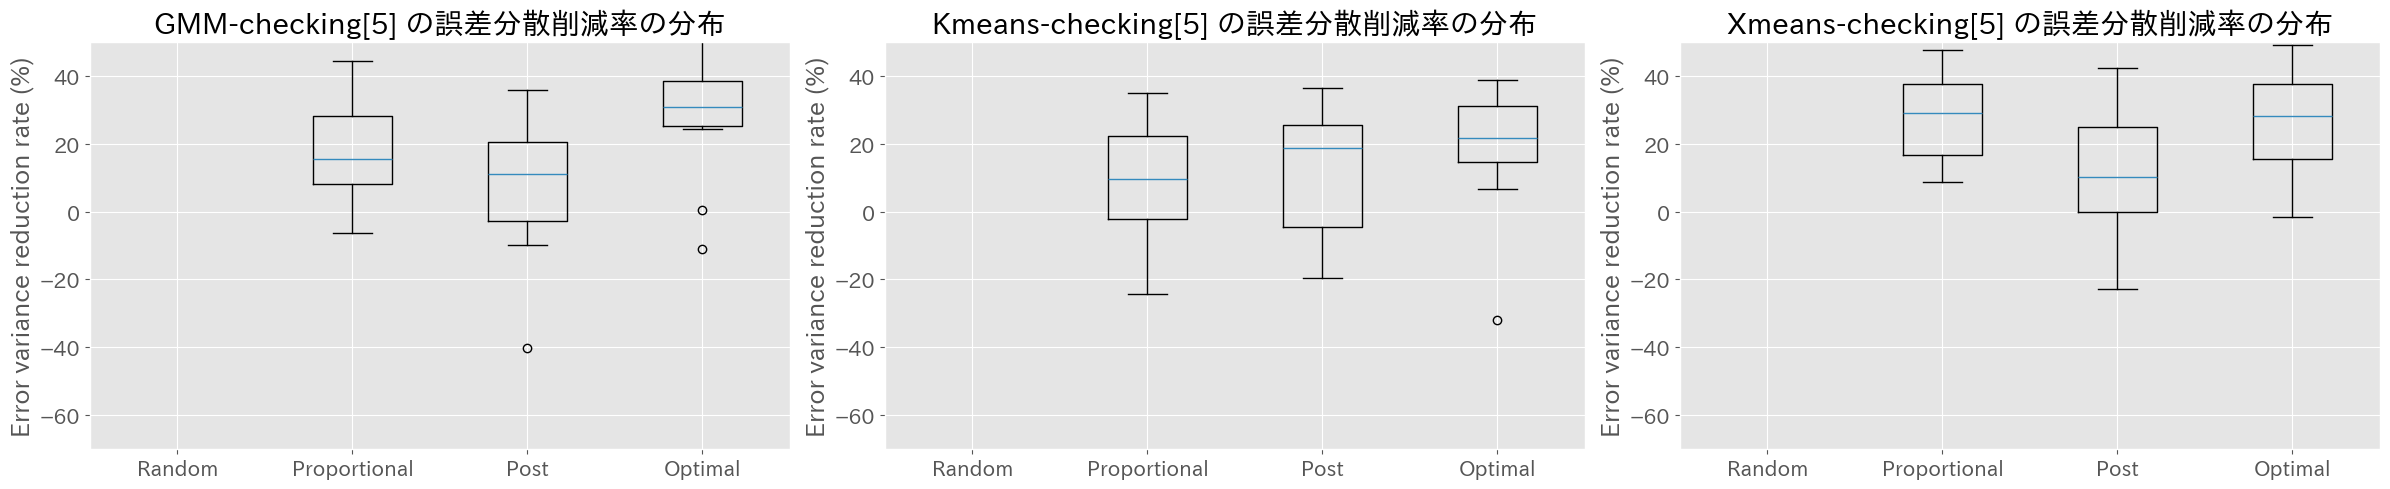

C:\Users\HaruMomozu\AppData\Local\Temp\ipykernel_20688\3617059436.py:45: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(allo_data, labels=allo_labels)  # 箱ひげ図を描く
C:\Users\HaruMomozu\AppData\Local\Temp\ipykernel_20688\3617059436.py:45: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(allo_data, labels=allo_labels)  # 箱ひげ図を描く
C:\Users\HaruMomozu\AppData\Local\Temp\ipykernel_20688\3617059436.py:45: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(allo_data, labels=allo_labels)  # 箱ひげ図を描く


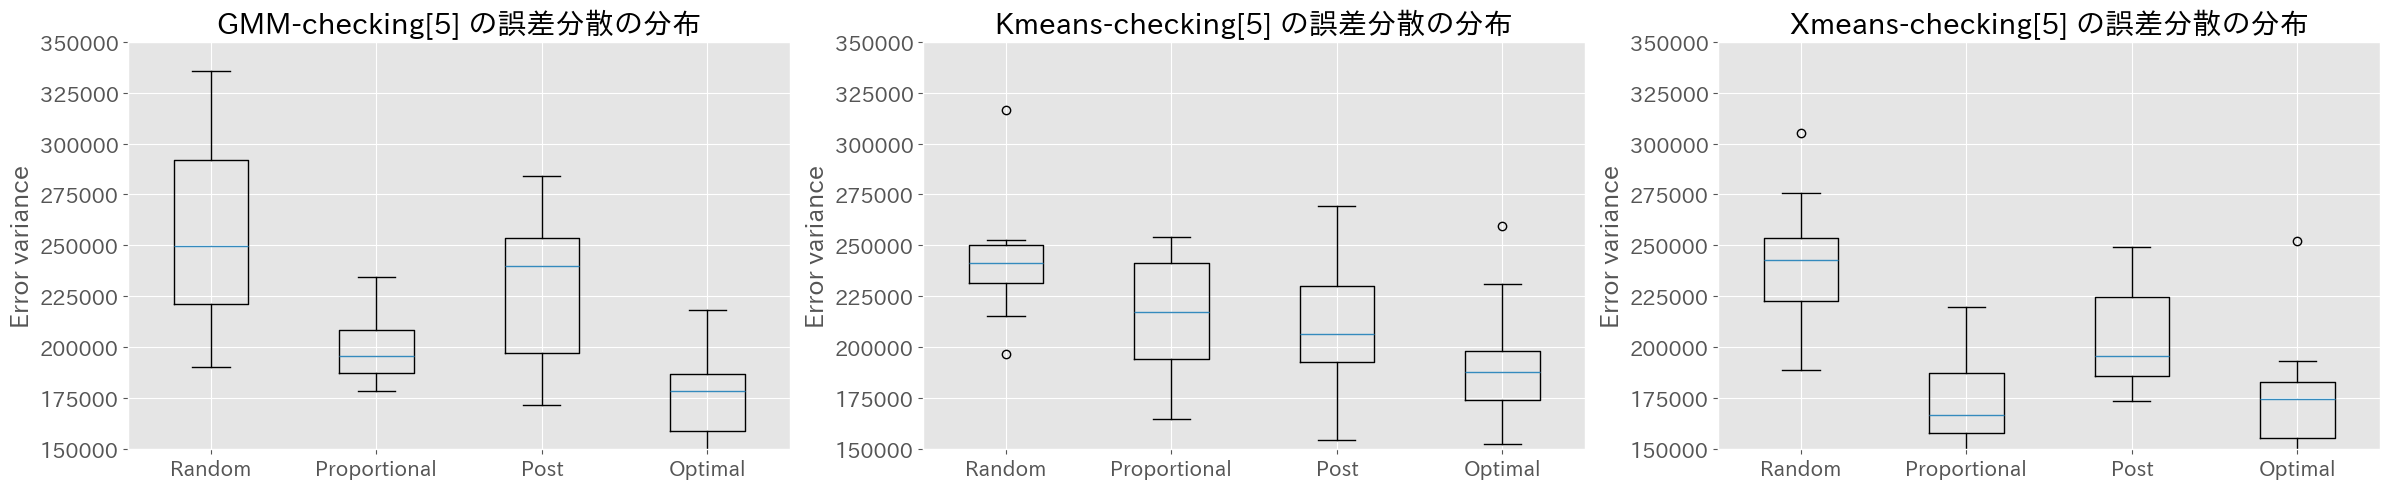

In [21]:
# 誤差分散削減率の箱ひげ図
fig, axs = plt.subplots(
    1, len(results_reduction_rate), figsize=(8 * len(results_reduction_rate), 5)
)  # サブプロットを作成


# 各methodに対して
plot_idx = 0  # サブプロットのインデックス
for i, (method, allocations) in enumerate(results_reduction_rate.items()):
    allo_data = list(allocations.values())  # allo1, allo2, allo3 のデータリスト
    allo_labels = list(allocations.keys())  # alloのラベルリスト
    if len(results_reduction_rate) == 1:
        ax = axs
    else:
        ax = axs[plot_idx]
    ax.boxplot(allo_data, labels=allo_labels)
    # グラフタイトルを設定
    ax.set_title(
        f"{method}{FEATURES_LIST_CHECKING} の誤差分散削減率の分布", fontsize=21
    )
    ax.set_ylabel("Error variance reduction rate (%)", fontsize=18)
    ax.tick_params(axis="both", which="major", labelsize=15)
    ax.set_ylim(-70, 50)
    plot_idx += 1

# グラフを表示
plt.tight_layout()  # レイアウトを調整
plt.show()


# 誤差分散の箱ひげ図
fig, axs = plt.subplots(
    1, len(results_error_variance), figsize=(8 * len(results_error_variance), 5)
)  # サブプロットを作成


plot_idx = 0  # サブプロットのインデックス
for i, (method, allocations) in enumerate(results_error_variance.items()):
    allo_data = list(allocations.values())  # allo1, allo2, allo3 のデータリスト
    allo_labels = list(allocations.keys())  # alloのラベルリスト
    if len(results_reduction_rate) == 1:
        ax = axs
    else:
        ax = axs[plot_idx]
    ax.boxplot(allo_data, labels=allo_labels)  # 箱ひげ図を描く
    ax.set_title(
        f"{method}{FEATURES_LIST_CHECKING} の誤差分散の分布", fontsize=21
    )  # タイトル設定
    ax.set_ylabel("Error variance", fontsize=18)
    ax.tick_params(axis="both", which="major", labelsize=15)
    ax.set_ylim(150000, 350000)
    plot_idx += 1  # 次のサブプロットへ移動

# レイアウト調整して表示
plt.tight_layout()
plt.show()

posx and posy should be finite values


['Random', 'Proportional', 'Post', 'Optimal']
[nan, 18.671285486548385, 7.1588880911615735, 28.90189761593959]
['Random', 'Proportional', 'Post', 'Optimal']
[nan, 9.625161218690579, 12.837341397817244, 18.698506593737235]
['Random', 'Proportional', 'Post', 'Optimal']
[nan, 27.623615845174196, 12.543944469199806, 25.94424889673014]


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


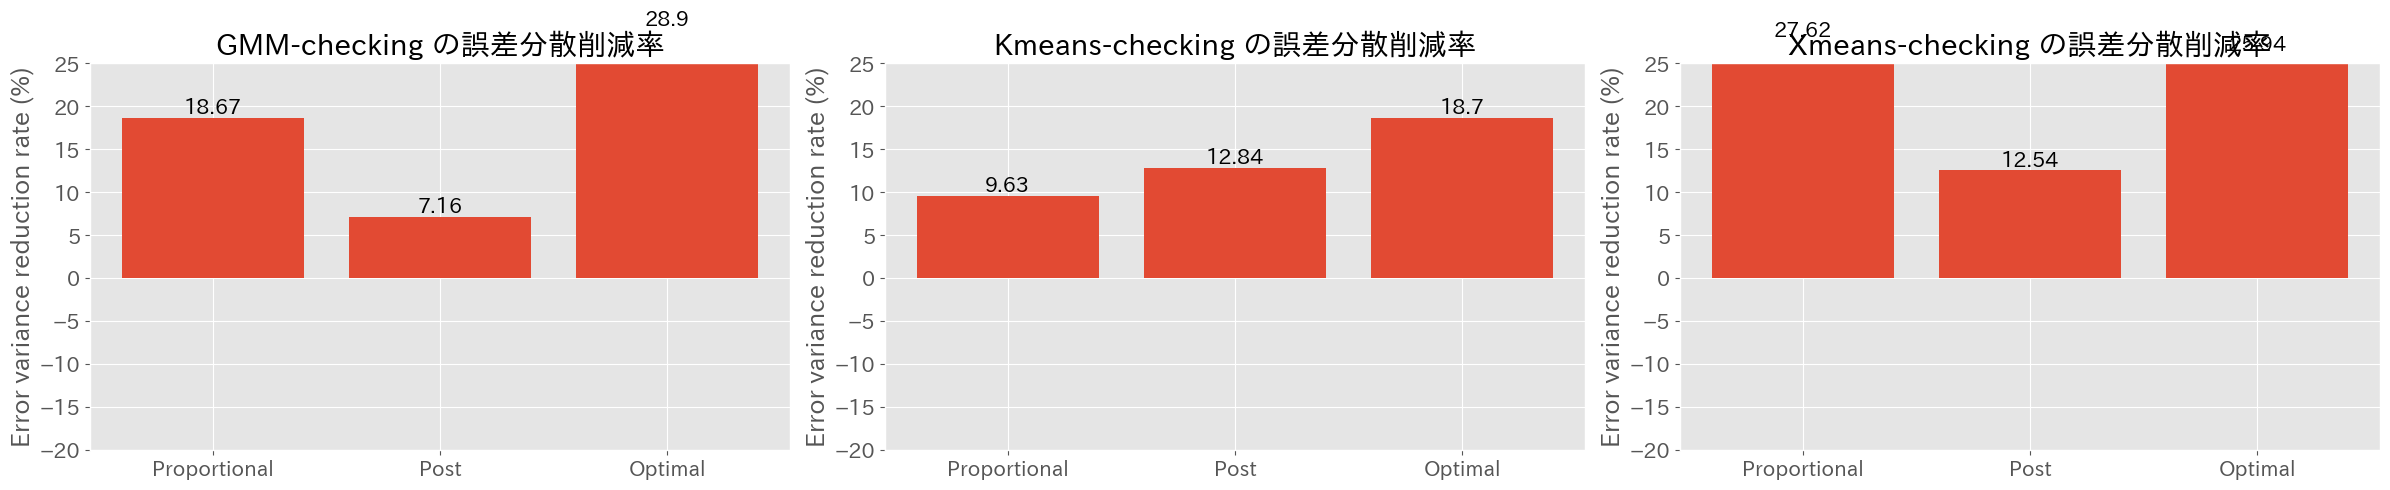

['Random', 'Proportional', 'Post', 'Optimal']
[254168.01174419193, 200488.28591901367, 229874.83591476284, 173988.08289875044]
['Random', 'Proportional', 'Post', 'Optimal']
[243016.83155784747, 215672.09539583727, 208059.35526612718, 193607.25852531233]
['Random', 'Proportional', 'Post', 'Optimal']
[241026.63887160807, 171846.50969689613, 205388.97621330866, 175575.4430020146]


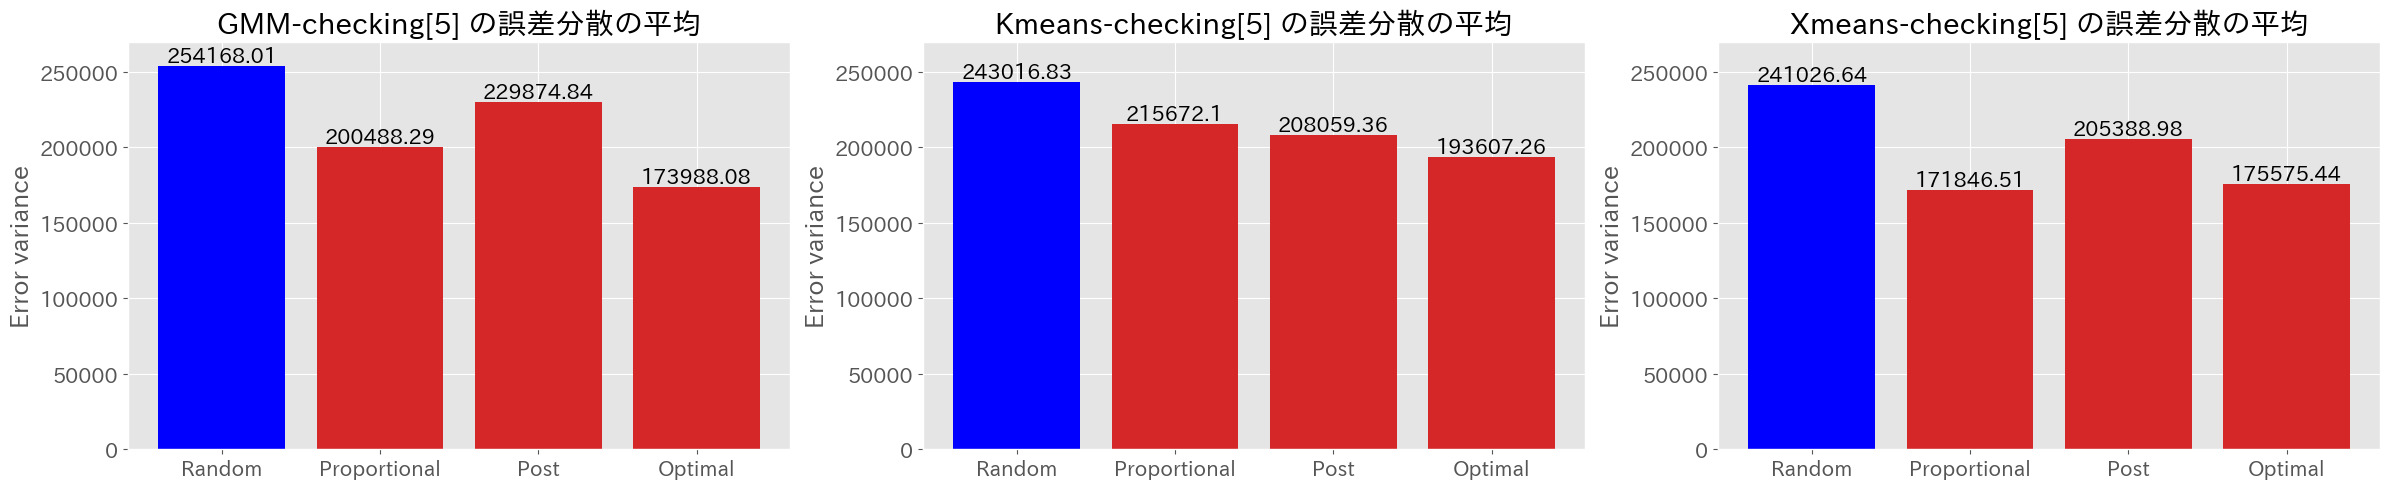

In [22]:
# グラフ作成
fig, axs = plt.subplots(
    1,
    len(mean_results_reduction_rate),
    figsize=(8 * len(mean_results_reduction_rate), 5),
)  # サブプロットを作成


plot_idx = 0
for method, dict in mean_results_reduction_rate.items():
    x = [a for a in ALLOCATION_LIST_AND_RANDOM]
    values = [val for val in mean_results_reduction_rate[method].values()]  # y軸
    print(x)
    print(values)
    if len(mean_results_reduction_rate) == 1:
        ax = axs
    else:
        ax = axs[plot_idx]
    bars = ax.bar(x, values)
    # 各バーの上に値を表示
    for bar in bars:
        yval = bar.get_height()  # 各バーの高さ（値）
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            yval,
            round(yval, 2),
            ha="center",
            va="bottom",
            fontsize=15,
        )  # 値をバーの上に表示
        # plt.ylabel("誤差分散削減率 (%)")
    ax.set_ylabel("Error variance reduction rate (%)", fontsize=18)
    ax.set_ylim(-20, 25)
    ax.tick_params(axis="both", which="major", labelsize=15)
    ax.set_title(
        f"{method} の誤差分散削減率", fontsize=21
    )  # (number of clusters: {clusters})")
    plot_idx += 1

plt.tight_layout()
plt.show()


# グラフ作成
fig, axs = plt.subplots(
    1,
    len(mean_results_error_variance),
    figsize=(8 * len(mean_results_error_variance), 5),
)  # サブプロットを作成


plot_idx = 0
for method, dict in mean_results_reduction_rate.items():
    x = [a for a in ALLOCATION_LIST_AND_RANDOM]
    values = [val for val in mean_results_error_variance[method].values()]  # y軸
    print(x)
    print(values)
    if len(mean_results_reduction_rate) == 1:
        ax = axs
    else:
        ax = axs[plot_idx]
    # bars = ax.bar(x, values)
    bars = ax.bar(
        x, values, color=["blue" if label == "Random" else "tab:red" for label in x]
    )
    # 各バーの上に値を表示
    for bar in bars:
        yval = bar.get_height()  # 各バーの高さ（値）
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            yval,
            round(yval, 2),
            ha="center",
            va="bottom",
            fontsize=15,
        )  # 値をバーの上に表示
        # plt.ylabel("誤差分散削減率 (%)")
    ax.set_ylabel("Error variance", fontsize=18)
    ax.set_ylim(0, 270000)
    ax.tick_params(axis="both", which="major", labelsize=15)
    ax.set_title(f"{method}{FEATURES_LIST_CHECKING} の誤差分散の平均", fontsize=21)
    plot_idx += 1

plt.tight_layout()
plt.show()